# Explanation 

This notebook is going to include all the models which are build using Neurol Networks approach. 
I specified some bunch of models that I am going to deploy. 

- to do: Models will be stayed here ! Dont forget !  

# Get the Data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 

data = pd.read_csv("/content/drive/MyDrive/datasets/deep_data_merged_all_class.csv")
data.head()

,Unnamed: 0,text,target
0,0,We know that effectively exercising your legs ...,0
1,1,Stressed out? 😩\r\nTired? 😴\r\nWorn down? 😰\r\...,0
2,2,Time to get rockin' and *foam* rollin' ! Last ...,0
3,3,"@that_zach_berg Hi Zach, can you please DM us?...",0
4,4,"@iam_rahulsingh @vikasjain1977 Hi, thank you f...",0


In [3]:
train_df_shuffled = data.sample(frac=1, random_state=42) 
train_df_shuffled.head() 

,Unnamed: 0,text,target
644,644,"@chriskrieger91 Hi, thanks for reaching out! W...",0
23615,4272,New episode of the @JalenRose: Renaissance Man...,5
17142,2680,Gordon Ramsay Hell’s Kitchen will open in Chic...,4
9962,468,"N95s, which seal tighter to the face, offer be...",2
19789,446,From exorcisms to weddings — the #Grammys have...,5


##### Balanced Dataset 

In [4]:
train_df_shuffled.target.value_counts()

3    4976
2    4968
5    4954
4    4881
1    4829
0    4665
Name: target, dtype: int64

In [5]:
import random 
random_index = random.randint(0, len(data) - 5) 

for  _, text, target in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 5 (real disaster)
Text:
#TheMaskedSinger sends not one but TWO mysterious singers packing! 🧳

https://t.co/GTF0sKXiwX

---

Target: 1 (real disaster)
Text:
RT @mwc13_3: I am thrilled to share my new Formula One Q&amp;A series, Fuel for Thought. Each week leading up to a race weekend, I'll chat with…

---

Target: 5 (real disaster)
Text:
Pregnant Houston Mother Days Away from Giving Birth to Son Is Fatally Shot in Her Car  https://t.co/ZerLUTNcxD

---

Target: 5 (real disaster)
Text:
#ChicagoFire‘s season 10 is coming to a close, which means the cast is understandably concerned about their characters’ fates. Exclusive interview with @DaMinoshow: https://t.co/cg6tg2PTfD

---

Target: 1 (real disaster)
Text:
The Gypsy King @Tyson_Fury has his next opponent 👑  @ESPNRingside https://t.co/OtAMUsT9xm

---



# Split data into training and validation sets

In [6]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2,
                                                                            random_state=42) 


In [7]:
train_labels

array([3, 2, 1, ..., 0, 3, 3])

In [8]:
import pandas as pd 

train_labels_dummy = pd.get_dummies(train_labels).astype('float32').values 
val_labels_dummy = pd.get_dummies(val_labels).astype('float32').values 

# Converting text into numbers

## Text vectorization (tokenization)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True)

In [10]:
# tweet başına kelime sayısı 
round( 
    sum(
        [len(i.split()) for i in train_sentences]
    ) / len(train_sentences)
) 

18

In [11]:
max_vocab_length = 10000 
max_length = 18 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    output_sequence_length=max_length)

In [12]:
text_vectorizer.adapt(train_sentences)

In [13]:
sample_sentence = "There is a flood in my suburb!" 
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 18), dtype=int64, numpy=
array([[109,   9,   5,   1,   6,  81,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]])>

In [14]:
text_vectorizer(train_sentences).numpy().flatten()

array([ 1,  1, 10, ...,  0,  0,  0])

In [15]:
val_counts = pd.Series(text_vectorizer(train_sentences).numpy().flatten()).value_counts()[:100]
val_counts 

0      88688
1      47650
2      11202
3       8212
5       5562
       ...  
82       316
99       315
105      312
102      304
109      303
Length: 100, dtype: int64

In [16]:
index_of_words = [] 
vcb = text_vectorizer.get_vocabulary()
for idx in val_counts.index:
  index_of_words.append(vcb[idx]) 

val_counts.index = index_of_words

In [17]:
val_counts =val_counts[50:70]  

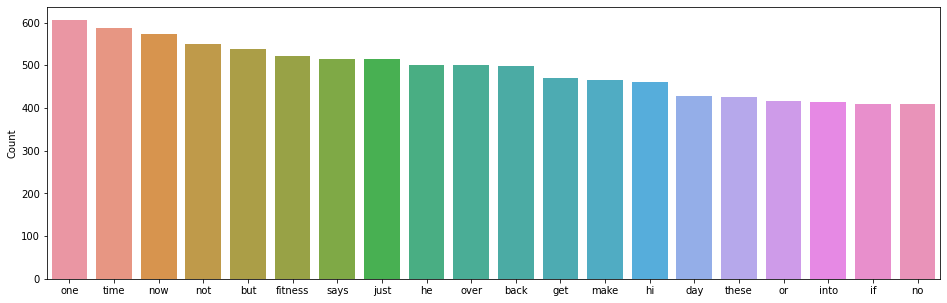

In [18]:
import seaborn as sns  
import matplotlib.pyplot as plt 

plt.figure(figsize=(16,5)) 
ax = sns.barplot(x=val_counts.index, y=val_counts.values)
ax.set(ylabel = 'Count') 
plt.show() 

## Embedding Layer  

In [19]:
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128,
                             input_length=max_length,
                             name="embedding_1") 

embedding

In [20]:
embedding(text_vectorizer(train_sentences[0]))

<tf.Tensor: shape=(18, 128), dtype=float32, numpy=
array([[ 0.02400735, -0.03540869, -0.00105493, ...,  0.03280662,
        -0.03201423,  0.01775653],
       [ 0.02400735, -0.03540869, -0.00105493, ...,  0.03280662,
        -0.03201423,  0.01775653],
       [ 0.03580245,  0.04345231, -0.02358949, ...,  0.00020957,
         0.02167341,  0.04036223],
       ...,
       [-0.04810449, -0.04316186,  0.0152281 , ..., -0.02317214,
        -0.04627658, -0.01544409],
       [-0.04810449, -0.04316186,  0.0152281 , ..., -0.02317214,
        -0.04627658, -0.01544409],
       [-0.04810449, -0.04316186,  0.0152281 , ..., -0.02317214,
        -0.04627658, -0.01544409]], dtype=float32)>

In [21]:
initial_embedding_weigths = embedding.get_weights() 

In [22]:
# embedding.set_weights(initial_embedding_weigths)

In [23]:
train_sentences.shape,train_labels.shape

((23418,), (23418,))

## Build Models 
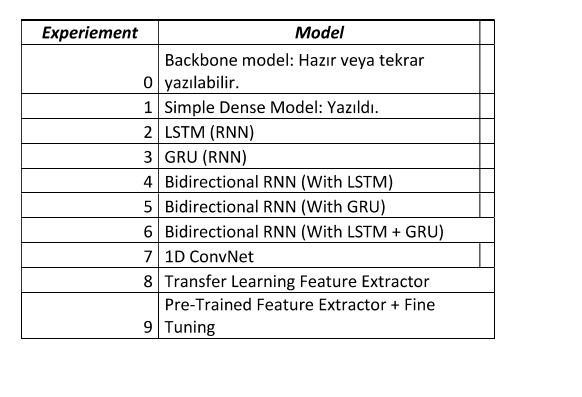

### Model 0: Baseline (Naive Bayes) 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf 
    ("clf", MultinomialNB()) # model the text 
])

model_0.fit(train_sentences, train_labels) 

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 88.37%


In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
results = dict() 
results["model_0_val"] = {
    "accuracy": model_0.score(val_sentences, val_labels), 
    "macro_f1-score": f1_score(val_labels,model_0.predict(val_sentences), average="macro"), 
    "macro_precision": precision_score(val_labels,model_0.predict(val_sentences), average="macro"), 
    "macro_recall": recall_score(val_labels,model_0.predict(val_sentences), average="macro")
}

results["model_0_train"] = {
    "accuracy": model_0.score(train_sentences, train_labels), 
    "macro_f1-score": f1_score(train_labels,model_0.predict(train_sentences), average="macro"), 
    "macro_precision": precision_score(train_labels,model_0.predict(train_sentences), average="macro"), 
    "macro_recall": recall_score(train_labels,model_0.predict(train_sentences), average="macro")
}

pd.DataFrame(results)

,model_0_val,model_0_train
accuracy,0.883689,0.950038
macro_f1-score,0.881762,0.949560
macro_precision,0.884194,0.950675
macro_recall,0.882536,0.949442


In [27]:
val_labels 

array([2, 3, 2, ..., 0, 2, 5])

In [28]:
from sklearn.metrics import classification_report 
y_hat_validation = model_0.predict(val_sentences)
y_hat_train = model_0.predict(train_sentences) 

report = classification_report(val_labels, y_hat_validation)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.75      0.80       921
           1       0.92      0.90      0.91       957
           2       0.88      0.96      0.92       995
           3       0.93      0.86      0.90      1044
           4       0.85      0.93      0.89       970
           5       0.86      0.88      0.87       968

    accuracy                           0.88      5855
   macro avg       0.88      0.88      0.88      5855
weighted avg       0.88      0.88      0.88      5855



### Model 1: A simple dense model


In [29]:
import numpy as np 

inputs = layers.Input(shape=(1,), dtype="string") # inputs 
x = text_vectorizer(inputs) 
x = embedding(x) # create an embedding of the numerized numbers 
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [30]:
model_1.summary() 


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 18, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1,280,774
Trainable params: 1,280,774
Non-tra

In [31]:
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"]) 

In [32]:
batch_size = train_sentences.shape[0] / 732
batch_size

31.991803278688526

In [33]:
model_1_history = model_1.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5)

Epoch 1/5
732/732 [==============================] - 6s 5ms/step - loss: 1.0948 - accuracy: 0.7168 - val_loss: 0.5769 - val_accuracy: 0.8441
Epoch 2/5
732/732 [==============================] - 4s 5ms/step - loss: 0.3980 - accuracy: 0.8920 - val_loss: 0.3889 - val_accuracy: 0.8810
Epoch 3/5
732/732 [==============================] - 3s 5ms/step - loss: 0.2473 - accuracy: 0.9302 - val_loss: 0.3353 - val_accuracy: 0.8926
Epoch 4/5
732/732 [==============================] - 3s 5ms/step - loss: 0.1741 - accuracy: 0.9513 - val_loss: 0.3169 - val_accuracy: 0.8958
Epoch 5/5
732/732 [==============================] - 3s 5ms/step - loss: 0.1287 - accuracy: 0.9653 - val_loss: 0.3140 - val_accuracy: 0.8999


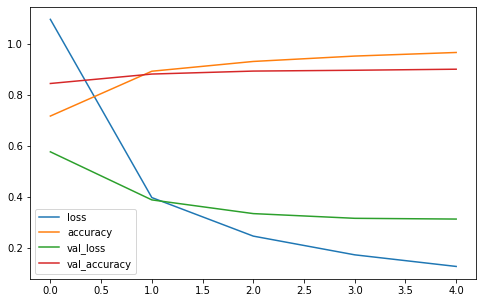

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(model_1_history.history).plot(figsize=(8, 5))
plt.show()

In [35]:
results["model_1_val"] = {
    "accuracy": model_1.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_1.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_1.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_1.predict(val_sentences), axis=1), average="macro")
}

results["model_1_train"] = {
    "accuracy": model_1.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_1.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_1.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_1.predict(train_sentences), axis=1), average="macro")
}

732/732 [==============================] - 2s 2ms/step


In [36]:
pd.DataFrame(results)

,model_0_val,model_0_train,model_1_val,model_1_train
accuracy,0.883689,0.950038,0.899915,0.977282
macro_f1-score,0.881762,0.949560,0.899138,0.977117
macro_precision,0.884194,0.950675,0.899223,0.977134
macro_recall,0.882536,0.949442,0.899117,0.977165


### Model 2: LSTM 

In [37]:
embedding.set_weights(initial_embedding_weigths)

In [38]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, activation="tanh")(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

In [39]:
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 
model_2_history = model_2.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5)

Epoch 1/5
732/732 [==============================] - 10s 7ms/step - loss: 0.6964 - accuracy: 0.7541 - val_loss: 0.4133 - val_accuracy: 0.8649
Epoch 2/5
732/732 [==============================] - 5s 7ms/step - loss: 0.2411 - accuracy: 0.9222 - val_loss: 0.3661 - val_accuracy: 0.8806
Epoch 3/5
732/732 [==============================] - 5s 7ms/step - loss: 0.1414 - accuracy: 0.9564 - val_loss: 0.4085 - val_accuracy: 0.8745
Epoch 4/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0962 - accuracy: 0.9700 - val_loss: 0.4557 - val_accuracy: 0.8716
Epoch 5/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0716 - accuracy: 0.9770 - val_loss: 0.5397 - val_accuracy: 0.8675


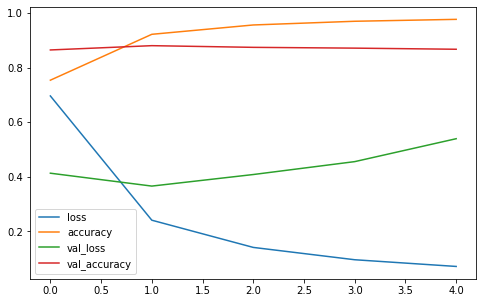

In [40]:
pd.DataFrame(model_2_history.history).plot(figsize=(8, 5))
plt.show()

- Over-fitting problem over here. 

In [41]:
results["model_2_val"] = {
    "accuracy": model_2.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_2.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_2.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_2.predict(val_sentences), axis=1), average="macro")
}

results["model_2_train"] = {
    "accuracy": model_2.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_2.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_2.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_2.predict(train_sentences), axis=1), average="macro")
}

732/732 [==============================] - 2s 3ms/step


In [42]:
pd.DataFrame(results)

,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129


### Model 3: GRU 

In [43]:
embedding.set_weights(initial_embedding_weigths)

In [44]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

In [45]:
model_3.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 
model_3_history = model_2.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5)

Epoch 1/5
732/732 [==============================] - 5s 7ms/step - loss: 0.4859 - accuracy: 0.8305 - val_loss: 0.3573 - val_accuracy: 0.8777
Epoch 2/5
732/732 [==============================] - 5s 7ms/step - loss: 0.1573 - accuracy: 0.9489 - val_loss: 0.3960 - val_accuracy: 0.8733
Epoch 3/5
732/732 [==============================] - 6s 8ms/step - loss: 0.0892 - accuracy: 0.9695 - val_loss: 0.4039 - val_accuracy: 0.8813
Epoch 4/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0581 - accuracy: 0.9800 - val_loss: 0.4951 - val_accuracy: 0.8736
Epoch 5/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0461 - accuracy: 0.9845 - val_loss: 0.5757 - val_accuracy: 0.8683


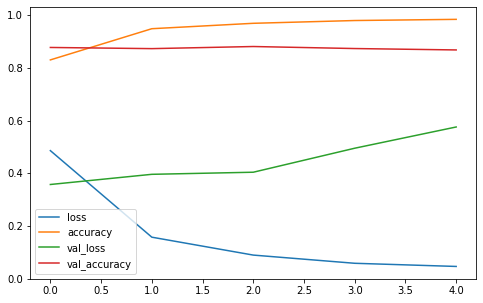

In [46]:
pd.DataFrame(model_3_history.history).plot(figsize=(8, 5))
plt.show()

In [47]:
results["model_3_val"] = {
    "accuracy": model_3.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_3.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_3.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_3.predict(val_sentences), axis=1), average="macro")
}

results["model_3_train"] = {
    "accuracy": model_3.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_3.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_3.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_3.predict(train_sentences), axis=1), average="macro")
}

pd.DataFrame(results)

732/732 [==============================] - 2s 3ms/step


,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train,model_3_val,model_3_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275,0.177114,0.185029
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155,0.129523,0.134246
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251,0.179322,0.182119
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129,0.178578,0.184924


### Model 4: Bidirectional RNN 

In [48]:
embedding.set_weights(initial_embedding_weigths)

In [49]:
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.Bidirectional(layers.LSTM(64))(x) 
outputs = layers.Dense(len(np.unique(train_labels)), activation="sigmoid")(x) 

model_4 = tf.keras.Model(
    inputs, 
    outputs, 
    name="model_4_bidirectional"
)

In [50]:
model_4.summary() 

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 18, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,379,590
Trainable params: 1,3

In [51]:
model_4.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["accuracy"] 
)

history_model_4 = model_4.fit(train_sentences,
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5) 

Epoch 1/5
732/732 [==============================] - 11s 10ms/step - loss: 0.6469 - accuracy: 0.7710 - val_loss: 0.3872 - val_accuracy: 0.8709
Epoch 2/5
732/732 [==============================] - 6s 9ms/step - loss: 0.2092 - accuracy: 0.9306 - val_loss: 0.3577 - val_accuracy: 0.8845
Epoch 3/5
732/732 [==============================] - 6s 9ms/step - loss: 0.1114 - accuracy: 0.9626 - val_loss: 0.3918 - val_accuracy: 0.8859
Epoch 4/5
732/732 [==============================] - 7s 9ms/step - loss: 0.0718 - accuracy: 0.9766 - val_loss: 0.4598 - val_accuracy: 0.8751
Epoch 5/5
732/732 [==============================] - 7s 10ms/step - loss: 0.0590 - accuracy: 0.9800 - val_loss: 0.5071 - val_accuracy: 0.8740


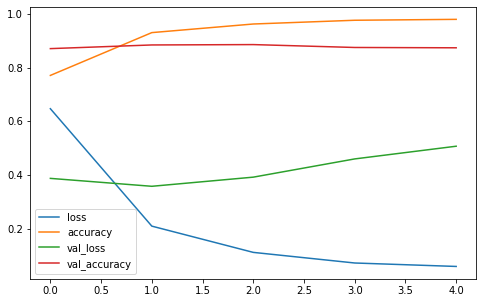

In [52]:
pd.DataFrame(history_model_4.history).plot(figsize=(8, 5))
plt.show()

In [53]:
results["model_4_val"] = {
    "accuracy": model_4.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_4.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_4.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_4.predict(val_sentences), axis=1), average="macro")
}

results["model_4_train"] = {
    "accuracy": model_4.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_4.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_4.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_4.predict(train_sentences), axis=1), average="macro")
}


pd.DataFrame(results)

732/732 [==============================] - 3s 4ms/step


,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train,model_3_val,model_3_train,model_4_val,model_4_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275,0.177114,0.185029,0.873954,0.990264
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155,0.129523,0.134246,0.873042,0.990189
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251,0.179322,0.182119,0.873996,0.990169
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129,0.178578,0.184924,0.872805,0.990272


### Model 5: Conv1D

In [54]:
embedding.set_weights(initial_embedding_weigths)

In [55]:
from tensorflow.keras import layers 

inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs)
x = embedding(x) 
x = layers.Conv1D(
    filters=32, 
    kernel_size=5, 
    strides=1, 
    padding="valid", 
    activation="relu"
)(x) 
x = layers.Conv1D(
    filters=32, 
    kernel_size=5, 
    strides=1, 
    padding="valid", 
    activation="relu"
)(x) 
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(len(np.unique(train_labels)), activation="sigmoid")(x) 
model_5 = tf.keras.Model(
    inputs,
    outputs, 
    name="model_5_conv_1d"
)

In [56]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_5 = model_5.fit(train_sentences,
                              train_labels_dummy,
                              epochs=5,
                              batch_size=32,
                              validation_data=(val_sentences, val_labels_dummy)
                              )

Epoch 1/5
732/732 [==============================] - 9s 6ms/step - loss: 0.8325 - accuracy: 0.6911 - val_loss: 0.4352 - val_accuracy: 0.8533
Epoch 2/5
732/732 [==============================] - 4s 6ms/step - loss: 0.2497 - accuracy: 0.9184 - val_loss: 0.3994 - val_accuracy: 0.8707
Epoch 3/5
732/732 [==============================] - 4s 6ms/step - loss: 0.1085 - accuracy: 0.9646 - val_loss: 0.4444 - val_accuracy: 0.8726
Epoch 4/5
732/732 [==============================] - 4s 6ms/step - loss: 0.0508 - accuracy: 0.9843 - val_loss: 0.5266 - val_accuracy: 0.8685
Epoch 5/5
732/732 [==============================] - 4s 6ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.6069 - val_accuracy: 0.8664


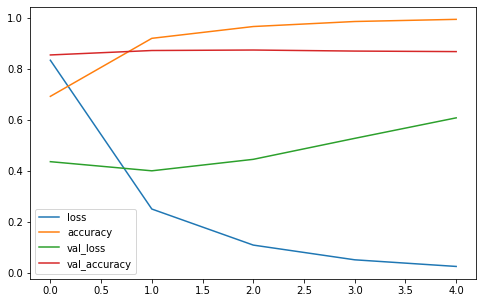

In [57]:
pd.DataFrame(history_model_5.history).plot(figsize=(8, 5))
plt.show()

In [58]:
results["model_5_val"] = {
    "accuracy": model_5.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_5.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_5.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_5.predict(val_sentences), axis=1), average="macro")
}

results["model_5_train"] = {
    "accuracy": model_5.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_5.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_5.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_5.predict(train_sentences), axis=1), average="macro")
}

732/732 [==============================] - 2s 3ms/step


In [59]:
pd.DataFrame(results)

,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train,model_3_val,model_3_train,model_4_val,model_4_train,model_5_val,model_5_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275,0.177114,0.185029,0.873954,0.990264,0.866439,0.996883
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155,0.129523,0.134246,0.873042,0.990189,0.865345,0.996853
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251,0.179322,0.182119,0.873996,0.990169,0.865908,0.996838
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129,0.178578,0.184924,0.872805,0.990272,0.865358,0.996875


## Applying Regularization 

In [60]:
from tensorflow.keras import regularizers
embedding_reg = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=32,
                             input_length=max_length,
                             name="embedding_regularized",
                             embeddings_regularizer=regularizers.L2(1e-5)) 

embedding_reg

In [61]:
embedding_reg(text_vectorizer(["hello"])) 

<tf.Tensor: shape=(1, 18, 32), dtype=float32, numpy=
array([[[ 4.8435185e-02,  9.3571432e-03, -1.4363598e-02,  6.6664927e-03,
          1.7437339e-03,  2.8032485e-02,  2.1056566e-02,  4.3763671e-02,
          2.9811356e-02,  6.0665384e-03,  3.3153001e-02,  4.1039024e-02,
          5.6245811e-03, -7.6305382e-03, -1.0804355e-02,  2.3090128e-02,
         -4.4920254e-02,  3.5191823e-02,  2.2045523e-04,  1.9785080e-02,
         -1.4192738e-02, -1.4969051e-02,  2.0705830e-02,  8.3097927e-03,
         -4.5486309e-02, -3.3719458e-02, -4.2507183e-02, -4.8830140e-02,
          2.6461553e-02, -4.3922137e-02,  1.8681213e-04,  4.6869520e-02],
        [ 4.6967156e-03,  4.0764179e-02,  2.5068942e-02, -2.8300298e-02,
          4.9142782e-02, -3.3074357e-02,  4.4087958e-02,  2.8888408e-02,
          3.8844530e-02,  5.2466393e-03, -7.8320131e-03,  3.9243829e-02,
         -2.8624428e-02,  3.2154273e-02,  2.9662792e-02, -4.1248500e-02,
         -2.2433698e-05, -4.4425011e-02,  2.9024515e-02, -4.5919765e-0

In [62]:
embedding_reg_initial_weights = embedding_reg.get_weights() 

In [63]:

inputs = layers.Input(shape=(1,), dtype="string") # inputs 
x = text_vectorizer(inputs) 
x = embedding_reg(x) # create an embedding of the numerized numbers 
x = layers.Dropout(0.4)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [64]:
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"]) 

model_1_history = model_1.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=10)

Epoch 1/10
732/732 [==============================] - 7s 9ms/step - loss: 1.4983 - accuracy: 0.6126 - val_loss: 1.0857 - val_accuracy: 0.7600
Epoch 2/10
732/732 [==============================] - 3s 4ms/step - loss: 0.8337 - accuracy: 0.8065 - val_loss: 0.6953 - val_accuracy: 0.8272
Epoch 3/10
732/732 [==============================] - 3s 4ms/step - loss: 0.5798 - accuracy: 0.8615 - val_loss: 0.5624 - val_accuracy: 0.8586
Epoch 4/10
732/732 [==============================] - 3s 5ms/step - loss: 0.4692 - accuracy: 0.8877 - val_loss: 0.5020 - val_accuracy: 0.8736
Epoch 5/10
732/732 [==============================] - 3s 5ms/step - loss: 0.4064 - accuracy: 0.9067 - val_loss: 0.4679 - val_accuracy: 0.8813
Epoch 6/10
732/732 [==============================] - 3s 5ms/step - loss: 0.3617 - accuracy: 0.9214 - val_loss: 0.4487 - val_accuracy: 0.8859
Epoch 7/10
732/732 [==============================] - 3s 4ms/step - loss: 0.3317 - accuracy: 0.9284 - val_loss: 0.4360 - val_accuracy: 0.8886
Epoch 

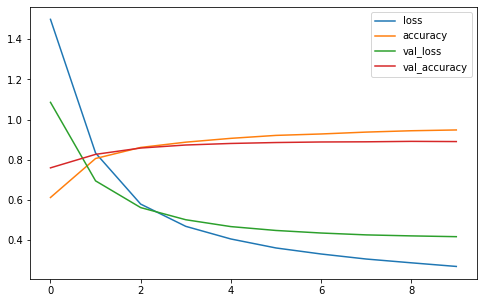

In [78]:
pd.DataFrame(model_1_history.history).plot(figsize=(8, 5))

In [65]:
results["model_1_reg_val"] = {
    "accuracy": model_1.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_1.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_1.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_1.predict(val_sentences), axis=1), average="macro")
}

results["model_1_reg_train"] = {
    "accuracy": model_1.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_1.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_1.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_1.predict(train_sentences), axis=1), average="macro")
}

pd.DataFrame(results)

732/732 [==============================] - 2s 2ms/step


,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train,model_3_val,model_3_train,model_4_val,model_4_train,model_5_val,model_5_train,model_1_reg_val,model_1_reg_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275,0.177114,0.185029,0.873954,0.990264,0.866439,0.996883,0.890692,0.963276
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155,0.129523,0.134246,0.873042,0.990189,0.865345,0.996853,0.889978,0.963037
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251,0.179322,0.182119,0.873996,0.990169,0.865908,0.996838,0.890231,0.963066
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129,0.178578,0.184924,0.872805,0.990272,0.865358,0.996875,0.889850,0.963103


In [66]:
embedding_reg.set_weights(embedding_reg_initial_weights)
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_reg(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(32, activation="tanh", recurrent_regularizer='l2')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 
model_2_history = model_2.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=10)

Epoch 1/10
732/732 [==============================] - 7s 7ms/step - loss: 1.2847 - accuracy: 0.5123 - val_loss: 0.6498 - val_accuracy: 0.8116
Epoch 2/10
732/732 [==============================] - 5s 6ms/step - loss: 0.5499 - accuracy: 0.8484 - val_loss: 0.4592 - val_accuracy: 0.8661
Epoch 3/10
732/732 [==============================] - 5s 6ms/step - loss: 0.3898 - accuracy: 0.8972 - val_loss: 0.4187 - val_accuracy: 0.8765
Epoch 4/10
732/732 [==============================] - 5s 6ms/step - loss: 0.3079 - accuracy: 0.9199 - val_loss: 0.4357 - val_accuracy: 0.8714
Epoch 5/10
732/732 [==============================] - 5s 6ms/step - loss: 0.2644 - accuracy: 0.9312 - val_loss: 0.4192 - val_accuracy: 0.8803
Epoch 6/10
732/732 [==============================] - 5s 6ms/step - loss: 0.2316 - accuracy: 0.9402 - val_loss: 0.4452 - val_accuracy: 0.8726
Epoch 7/10
732/732 [==============================] - 5s 6ms/step - loss: 0.2082 - accuracy: 0.9468 - val_loss: 0.4612 - val_accuracy: 0.8763
Epoch 

In [67]:
results["model_2_reg_val"] = {
    "accuracy": model_2.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_2.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_2.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_2.predict(val_sentences), axis=1), average="macro")
}

results["model_2_reg_train"] = {
    "accuracy": model_2.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_2.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_2.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_2.predict(train_sentences), axis=1), average="macro")
}

pd.DataFrame(results)

732/732 [==============================] - 2s 3ms/step


,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train,model_3_val,model_3_train,model_4_val,model_4_train,model_5_val,model_5_train,model_1_reg_val,model_1_reg_train,model_2_reg_val,model_2_reg_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275,0.177114,0.185029,0.873954,0.990264,0.866439,0.996883,0.890692,0.963276,0.878736,0.985780
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155,0.129523,0.134246,0.873042,0.990189,0.865345,0.996853,0.889978,0.963037,0.877847,0.985631
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251,0.179322,0.182119,0.873996,0.990169,0.865908,0.996838,0.890231,0.963066,0.878390,0.985665
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129,0.178578,0.184924,0.872805,0.990272,0.865358,0.996875,0.889850,0.963103,0.877652,0.985630


In [68]:
embedding_reg.set_weights(embedding_reg_initial_weights)
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding_reg(x) 
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(16, recurrent_regularizer='l2'))(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="sigmoid")(x) 

model_4 = tf.keras.Model(
    inputs, 
    outputs, 
    name="model_4_bidirectional"
)
model_4.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["accuracy"] 
)

history_model_4 = model_4.fit(train_sentences,
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=10) 

Epoch 1/10
732/732 [==============================] - 10s 9ms/step - loss: 1.2103 - accuracy: 0.5792 - val_loss: 0.5271 - val_accuracy: 0.8533
Epoch 2/10
732/732 [==============================] - 6s 8ms/step - loss: 0.4713 - accuracy: 0.8707 - val_loss: 0.4072 - val_accuracy: 0.8779
Epoch 3/10
732/732 [==============================] - 7s 9ms/step - loss: 0.3288 - accuracy: 0.9097 - val_loss: 0.3702 - val_accuracy: 0.8910
Epoch 4/10
732/732 [==============================] - 6s 8ms/step - loss: 0.2687 - accuracy: 0.9252 - val_loss: 0.3701 - val_accuracy: 0.8914
Epoch 5/10
732/732 [==============================] - 6s 8ms/step - loss: 0.2247 - accuracy: 0.9400 - val_loss: 0.3940 - val_accuracy: 0.8905
Epoch 6/10
732/732 [==============================] - 6s 8ms/step - loss: 0.2021 - accuracy: 0.9444 - val_loss: 0.3953 - val_accuracy: 0.8895
Epoch 7/10
732/732 [==============================] - 6s 8ms/step - loss: 0.1810 - accuracy: 0.9519 - val_loss: 0.4119 - val_accuracy: 0.8914
Epoch

In [69]:
train_sentences.shape

(23418,)

In [70]:
results["model_4_reg_val"] = {
    "accuracy": model_4.evaluate(val_sentences, val_labels_dummy)[1], 
    "macro_f1-score": f1_score(val_labels,np.argmax(model_4.predict(val_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(val_labels,np.argmax(model_4.predict(val_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(val_labels,np.argmax(model_4.predict(val_sentences), axis=1), average="macro")
}

results["model_4_reg_train"] = {
    "accuracy": model_4.evaluate(train_sentences, train_labels_dummy)[1], 
    "macro_f1-score": f1_score(train_labels,np.argmax(model_4.predict(train_sentences), axis=1), average="macro"), 
    "macro_precision": precision_score(train_labels,np.argmax(model_4.predict(train_sentences), axis=1), average="macro"), 
    "macro_recall": recall_score(train_labels,np.argmax(model_4.predict(train_sentences), axis=1), average="macro")
}

pd.DataFrame(results)

732/732 [==============================] - 3s 4ms/step


,model_0_val,model_0_train,model_1_val,model_1_train,model_2_val,model_2_train,model_3_val,model_3_train,model_4_val,model_4_train,model_5_val,model_5_train,model_1_reg_val,model_1_reg_train,model_2_reg_val,model_2_reg_train,model_4_reg_val,model_4_reg_train
accuracy,0.883689,0.950038,0.899915,0.977282,0.867464,0.987275,0.177114,0.185029,0.873954,0.990264,0.866439,0.996883,0.890692,0.963276,0.878736,0.985780,0.887276,0.986720
macro_f1-score,0.881762,0.949560,0.899138,0.977117,0.866044,0.987155,0.129523,0.134246,0.873042,0.990189,0.865345,0.996853,0.889978,0.963037,0.877847,0.985631,0.886503,0.986606
macro_precision,0.884194,0.950675,0.899223,0.977134,0.869101,0.987251,0.179322,0.182119,0.873996,0.990169,0.865908,0.996838,0.890231,0.963066,0.878390,0.985665,0.887518,0.986631
macro_recall,0.882536,0.949442,0.899117,0.977165,0.865646,0.987129,0.178578,0.184924,0.872805,0.990272,0.865358,0.996875,0.889850,0.963103,0.877652,0.985630,0.886234,0.986674


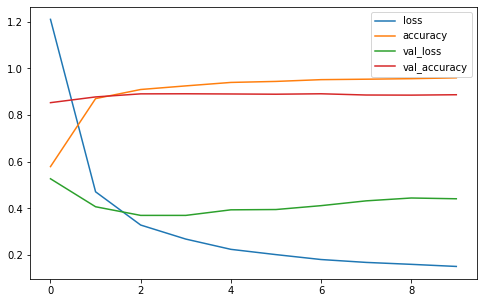

In [77]:
pd.DataFrame(history_model_4.history).plot(figsize=(8, 5))


In [71]:
df_results = pd.DataFrame(results) 
df_results.to_csv("reulst.csv")
df_results.to_excel("results.xlsx")

# Embedding Visualization 

In [72]:
# Get the weight matrix of embedding layer 
# these are the numerical representations of each token in our training data 
embed_weights = model_1.get_layer("embedding_regularized").get_weights()[0] 
embed_weights.shape

(10000, 32)

10000 is the length of the Vocabulary. <br>
32 is the lenght of the representation of each token.

In [73]:
vocab = text_vectorizer.get_vocabulary()

In [74]:
import io 

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [75]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>